## AlekseevDP(DSU-4, DLL-15)_HW#3_Сверточные НС

Задание: Используя сверточные слои и архитектуру, получите на FashionMNIST качество не ниже 89,5%

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np

In [2]:
import torchvision as tv
import time

In [3]:
from torch import nn

In [4]:
# зададим размер батча
BATCH_SIZE=256

In [5]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



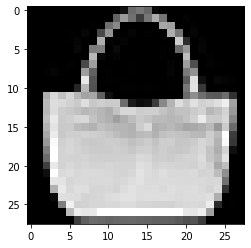

In [6]:
plt.imshow(train_dataset[100][0].numpy().reshape(28,28), cmap='gray')

In [7]:
train_dataset[100][0].shape

torch.Size([1, 28, 28])

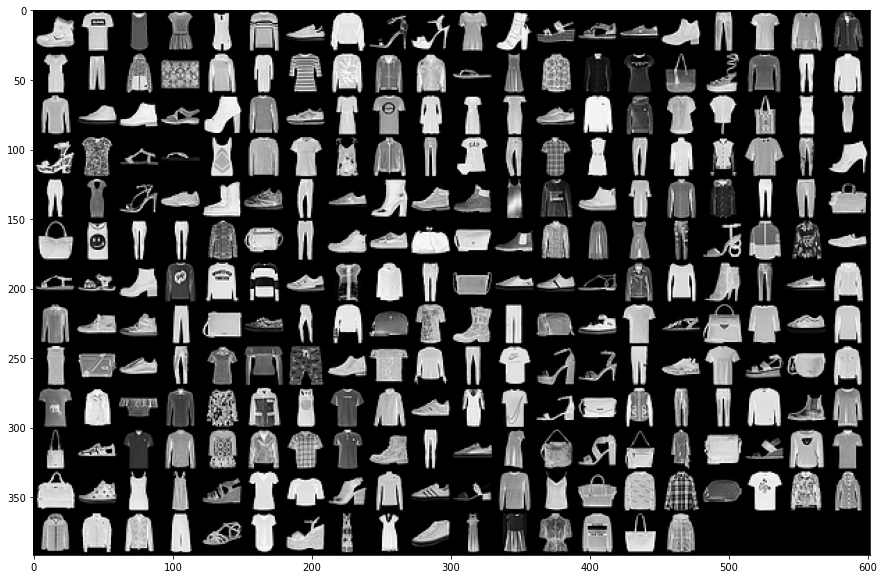

In [82]:
# посмотрим на трейн-выборку визуально
images, labels = next(iter(train_iter))
grid = tv.utils.make_grid(images,nrow=20)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

In [8]:
# запланируем НС в "базовом" варианте (№1)
torch.nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=300, out_features=50, bias=True)
  (8): ReLU()
  (9): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
# создадим НС в "базовом" варианте (вариант №1)
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [10]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [11]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [12]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [13]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [14]:
lr, num_epochs = 0.001, 30
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 1.0811, train acc 0.595, test acc 0.772, time 14.0 sec
epoch 2, loss 0.4967, train acc 0.814, test acc 0.837, time 14.0 sec
epoch 3, loss 0.4183, train acc 0.846, test acc 0.852, time 13.9 sec
epoch 4, loss 0.3805, train acc 0.861, test acc 0.858, time 13.9 sec
epoch 5, loss 0.3581, train acc 0.869, test acc 0.861, time 13.9 sec
epoch 6, loss 0.3407, train acc 0.874, test acc 0.865, time 13.8 sec
epoch 7, loss 0.3277, train acc 0.879, test acc 0.865, time 13.8 sec
epoch 8, loss 0.3169, train acc 0.883, test acc 0.870, time 13.8 sec
epoch 9, loss 0.3077, train acc 0.886, test acc 0.872, time 13.6 sec
epoch 10, loss 0.2997, train acc 0.889, test acc 0.874, time 13.6 sec
epoch 11, loss 0.2925, train acc 0.892, test acc 0.879, time 13.5 sec
epoch 12, loss 0.2860, train acc 0.894, test acc 0.881, time 13.6 sec
epoch 13, loss 0.2807, train acc 0.897, test acc 0.885, time 13.6 sec
epoch 14, loss 0.2748, train acc 0.899, test acc 0.886, time 13.8 sec
epoch 15, loss 0.2694, train 

## Заданной точности в 89,5% на тестовой выборке в базовом варианте достичь не удалось. Попробуем изменить структуру НС.

In [15]:
# добавим 2 дроп-аута по 30% (вариант №2)
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.Dropout(p=0.30), # p – probability of an element to be zeroed. Default: 0.5
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Dropout(p=0.30), # p – probability of an element to be zeroed. Default: 0.5
    nn.Linear(50, 10)
)

In [16]:
lr, num_epochs = 0.001, 30
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 1.0606, train acc 0.593, test acc 0.753, time 15.6 sec
epoch 2, loss 0.5833, train acc 0.779, test acc 0.809, time 15.0 sec
epoch 3, loss 0.4986, train acc 0.816, test acc 0.818, time 15.6 sec
epoch 4, loss 0.4536, train acc 0.833, test acc 0.828, time 15.2 sec
epoch 5, loss 0.4335, train acc 0.841, test acc 0.845, time 15.1 sec
epoch 6, loss 0.4153, train acc 0.848, test acc 0.843, time 15.2 sec
epoch 7, loss 0.3985, train acc 0.854, test acc 0.850, time 15.0 sec
epoch 8, loss 0.3840, train acc 0.860, test acc 0.855, time 15.0 sec
epoch 9, loss 0.3777, train acc 0.861, test acc 0.851, time 14.9 sec
epoch 10, loss 0.3662, train acc 0.868, test acc 0.859, time 15.0 sec
epoch 11, loss 0.3554, train acc 0.870, test acc 0.866, time 15.0 sec
epoch 12, loss 0.3526, train acc 0.870, test acc 0.865, time 15.2 sec
epoch 13, loss 0.3466, train acc 0.873, test acc 0.866, time 14.9 sec
epoch 14, loss 0.3426, train acc 0.875, test acc 0.869, time 15.1 sec
epoch 15, loss 0.3374, train 

## Качество в данном случае получилось ниже, чем без дроп-аутов. 

In [71]:
#  вариант №3: Попробуем убрать дроп-ауты, изменить кол-во каналов в слоях,
# а также применить батч-нормализацию.
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=5, padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Flatten(),
    nn.Linear(1568, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

In [72]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 0.4423, train acc 0.853, test acc 0.885, time 45.2 sec
epoch 2, loss 0.2667, train acc 0.905, test acc 0.894, time 43.4 sec
epoch 3, loss 0.2277, train acc 0.918, test acc 0.898, time 43.1 sec
epoch 4, loss 0.2019, train acc 0.927, test acc 0.899, time 43.0 sec
epoch 5, loss 0.1811, train acc 0.934, test acc 0.894, time 43.0 sec
epoch 6, loss 0.1626, train acc 0.942, test acc 0.900, time 43.1 sec
epoch 7, loss 0.1463, train acc 0.948, test acc 0.901, time 43.5 sec
epoch 8, loss 0.1319, train acc 0.954, test acc 0.902, time 44.1 sec
epoch 9, loss 0.1181, train acc 0.959, test acc 0.904, time 43.2 sec
epoch 10, loss 0.1068, train acc 0.963, test acc 0.904, time 43.3 sec


## Мы видим, что заданной точности в 89.5% на тестовой выборке удалось достичь уже на 3-ей эпохе, далее качество предсказаний продолжило расти. Попробуем оценить визуально точность предсказаний.

In [73]:
import random

In [130]:
# сперва переведем модель в режим оценки, иначе в трейн-режиме будет выдавать ошибку 
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=32, bias=True)
  (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=10, bias=True)
)

In [180]:
x_test, y_test = next(iter(test_iter))

In [181]:
order_list = "Футболка Брюки Пуловер/свитер Платье Пальто Сандалии/босоножки Рубашка Кроссовки Сумка Ботинки".split()

Это Пуловер/свитер


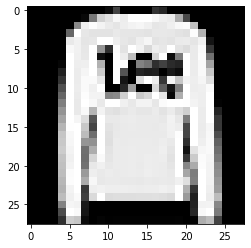

In [183]:
item = random.randint(0, 256)

plt.imshow(x_test[item].reshape(28,28),cmap='gray')
pred = model(x_test[item].reshape(-1,1,28,28)).argmax()
print("Это {}".format(order_list[pred]))

Это Сумка


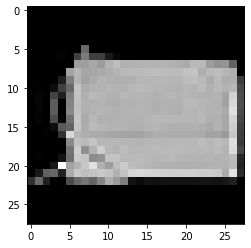

In [185]:
item = random.randint(0, 256)

plt.imshow(x_test[item].reshape(28,28),cmap='gray')
pred = model(x_test[item].reshape(-1,1,28,28)).argmax()
print("Это {}".format(order_list[pred]))

Это Сандалии/босоножки


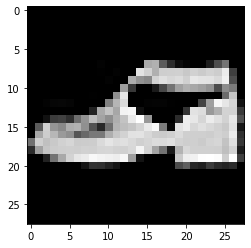

In [205]:
item = random.randint(0, 256)

plt.imshow(x_test[item].reshape(28,28),cmap='gray')
pred = model(x_test[item].reshape(-1,1,28,28)).argmax()
print("Это {}".format(order_list[pred]))